This notebook picks a bunch of healpix pixels, and renders a nice picture of it

In [454]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp
import images
import NFW

import astropy.cosmology as cosmology

import multiprocessing as mp

import galsim
import meds

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.mcal as mcal


In [86]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [87]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

In [88]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])

In [89]:
pixel_id = 0

In [90]:
alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

In [91]:
pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

# This is the pre injection canvas

In [92]:
pixel_scale = 0.264
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = table["ra"]
mock_catalog["DEC"] = table["dec"]
mock_catalog["X"] = (table["ra"] - ra_cen) * 60 * 60 / pixel_scale + 2499.5
mock_catalog["Y"] = (table["dec"] - dec_cen) * 60 * 60 / pixel_scale + 2499.5

mock_catalog["MAG_I"] = table["mag_i"]
mock_catalog["TSIZE"] = table["size_true"]
mock_catalog["FRACDEV"] = 0
mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
mock_catalog["G1"] = table["ellipticity_1_true"]
mock_catalog["G2"] = table["ellipticity_2_true"]

In [188]:
def make_mock(table, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    pixel_scale = 0.264
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"]
    mock_catalog["FRACDEV"] = 0
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]    
    return mock_catalog

def radec2xy(ra, dec, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    x = (ra - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    y = (dec - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]
    return x.values, y.values

In [119]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

In [78]:
len(table) / (0.1 * 60)**2.

378.6666666666667

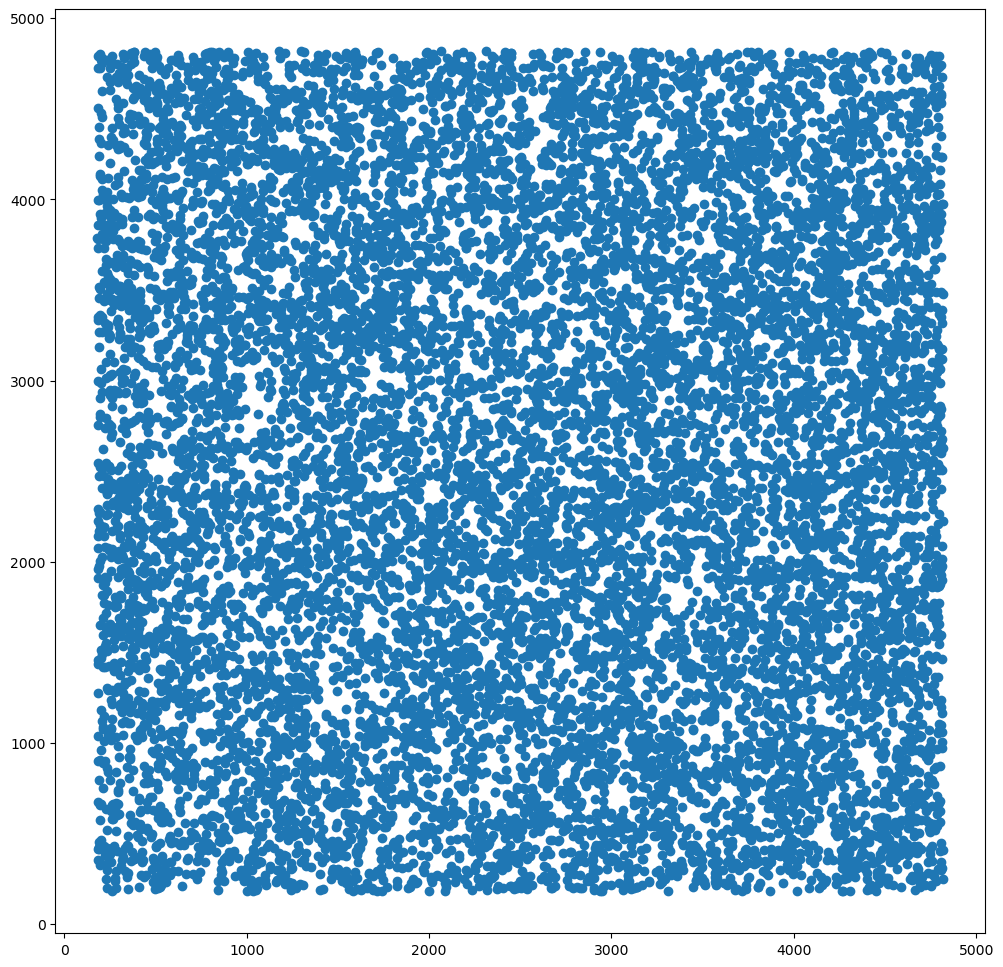

In [79]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [121]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i
starting xshear calculations in 100 processes


In [122]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i.fits


0.9392495155334473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


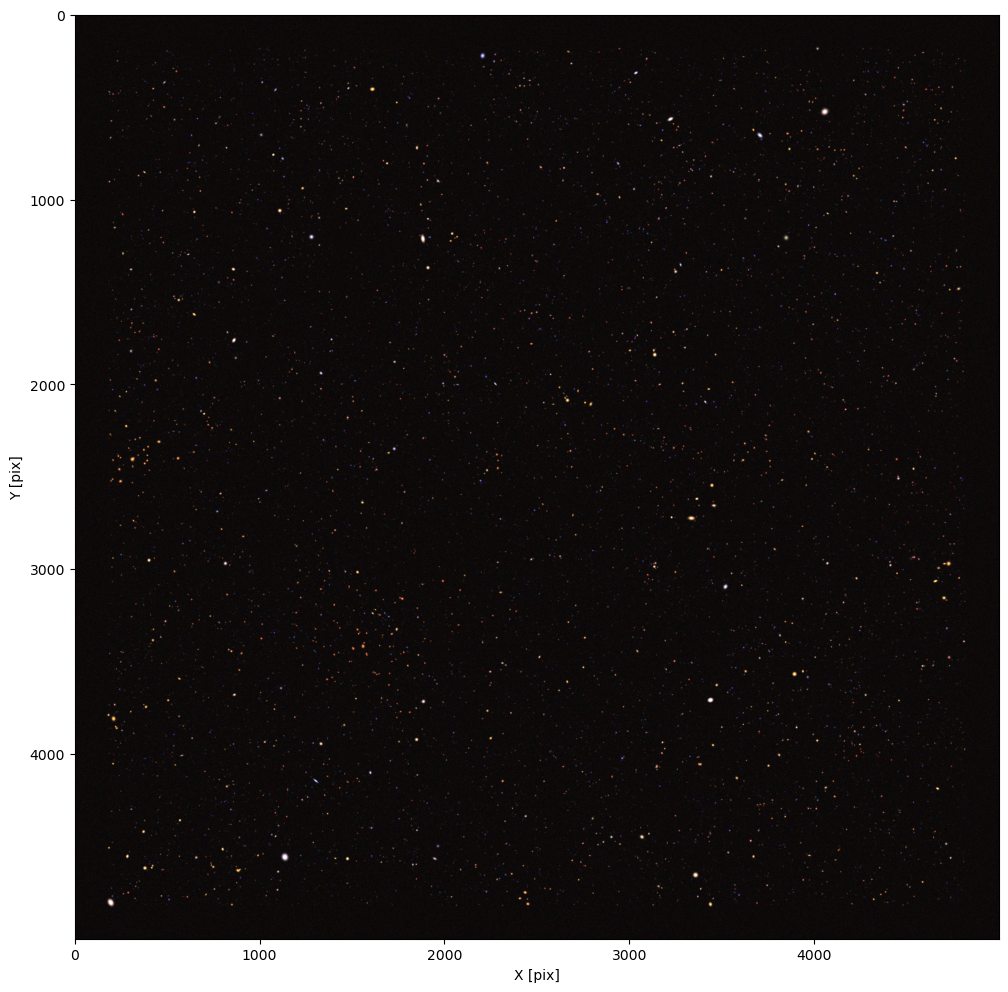

In [211]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp.png", bbox_inches='tight')

Let's look at the most masive 10 halos in more detail

In [212]:
ihmaxes = np.argsort(table["halo_mass"])[::-1]

In [213]:
masses = table["halo_mass"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
ras = table["ra"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
decs = table["dec"][table["is_central"]].iloc[np.argsort(table["halo_mass"][table["is_central"]])[-10:]]
xh, yh = radec2xy(ras, decs, sky_center=(ra_cen, dec_cen))

In [214]:
marker_sizes = (np.log10(masses).values - 12.6) ** 4 * 30

array([3416.46127751, 3807.58707247, 2403.74171904, 1606.1850579 ,
        470.39581575, 2831.61123797, 4748.17560675, 1435.60652068,
       1519.76691823, 4176.4363955 ])

0.9392495155334473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


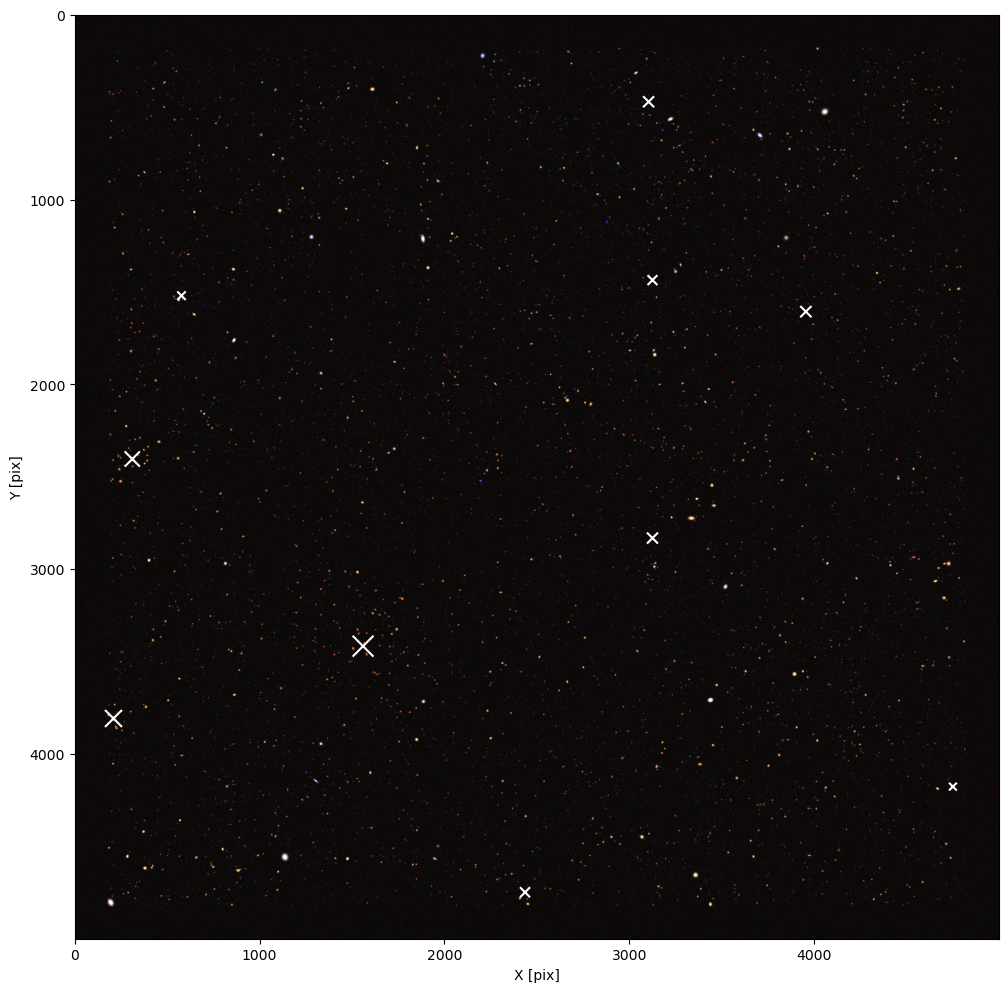

In [220]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')
ax.scatter(xh[::-1], yh[::-1], s=marker_sizes[::-1], color="white", marker="x")

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp_halos_in_FOV.png", bbox_inches='tight')

In [144]:
table['halo_mass'].iloc[ihmaxes[:10]]

661956    1.808167e+14
661977    1.808167e+14
661963    1.808167e+14
661964    1.808167e+14
661965    1.808167e+14
661966    1.808167e+14
661967    1.808167e+14
661968    1.808167e+14
661969    1.808167e+14
661970    1.808167e+14
Name: halo_mass, dtype: float64

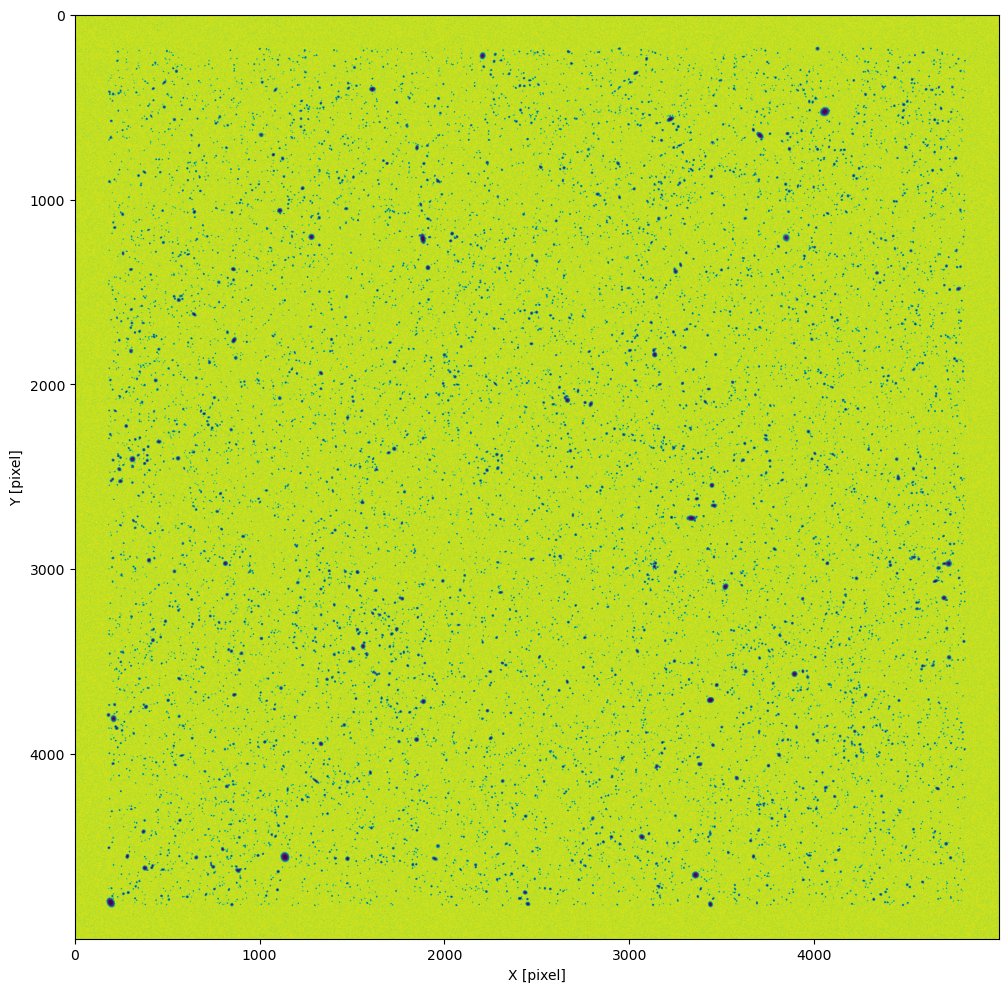

In [84]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr)
ax.set_xlabel("X [pixel]")
ax.set_ylabel("Y [pixel]")

fig.savefig("DC2_noinject_render.png")

# Making some extra strong Isothermal shears

In [259]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [260]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

xra = (mock_catalog['X'] - 2499.5) * 0.264 / 60 # arcmin
ydec = (mock_catalog['Y'] - 2499.5) * 0.264 / 60 # arcmin
dists = np.sqrt(xra**2 + ydec**2)
shears = np.sqrt(1 / dists  / 2) # just for illustration purposes
shears[shears > 0.8] = 0.8

phis =  np.arctan2(ydec, xra)
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))
mock_catalog["G1"] = es1
mock_catalog["G2"] = es2

# dists = np.sqrt((mock_catalog["RA"] - ra_cen)**2 + (mock_catalog["DEC"] - dec_cen)**2)
# shears = np.sqrt(1 / (dists * 30)  / 3) # just for illustration purposes
# shears[shears > 0.8] = 0.8

# phis =  np.arctan2(mock_catalog["DEC"], mock_catalog["RA"])
# es1 = (-1. * shears * np.cos(2 * phis))
# es2 = (-1. * shears * np.sin(2 * phis))

# mock_catalog["G1"] = es1
# mock_catalog["G2"] = es2

# e1 = mock_catalog["G1"]
# e2 = mock_catalog["G2"]

# vals1 = e1 + es1 - e1 * es1 - e2 * es2
# vals2 = e2 + es2 - es1 * e2 + es2 * e1

# tmp = np.sqrt(vals1**2. + vals2**2.)
# ii = tmp > 0.95
# divs = 1. / (0.1 + tmp[ii])  
# vals1[ii] *= divs
# vals2[ii] *= divs

# mock_catalog["G1"] = vals1
# mock_catalog["G2"] = vals2

## This is where we test the tangential shear profile

In [476]:
def get_tangential(xpos, ypos, e1, e2, center):
    """The center is where th aperture is"""
    dists = np.sqrt((ypos - center[1])**2. + (xpos - center[0])**2.)
    phis = np.arctan2(ypos - center[1], xpos - center[0])
    tshears = -e1 * np.cos(2 * phis) - e2 * np.sin(2 * phis)
    return tshears, dists

In [477]:
tshear, rarr = get_tangential(mock_catalog["X"], mock_catalog["Y"], es1, es2, (2499.5, 2499.5))

## Rendering and detecting

In [256]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_isothermal_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_i
starting xshear calculations in 100 processes


In [257]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_isothermal_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_i.fits


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9455214738845825


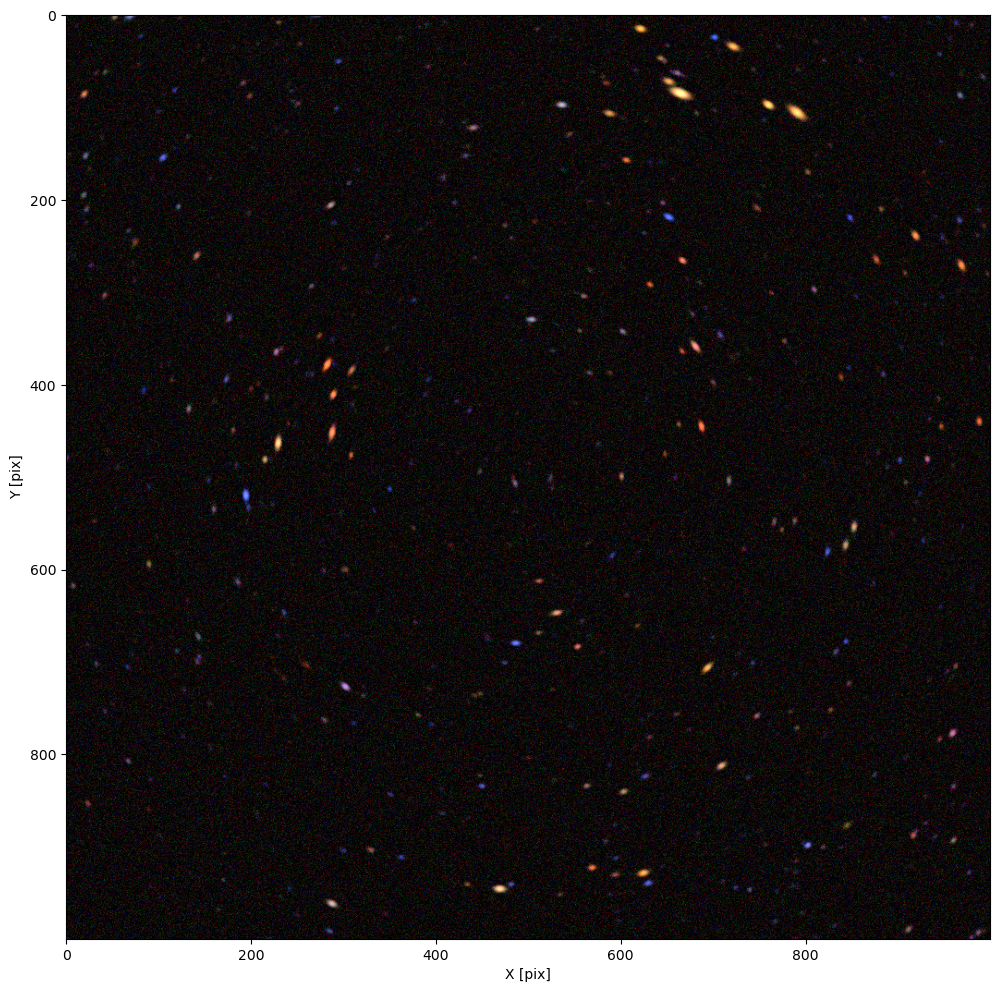

In [258]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2000:3000, 2000:3000] * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
fig.savefig("dc2_hp_isothermal.png", bbox_inches='tight')

## Render a deeper mock coadd and run sextractor

In [268]:
name = folder_path + 'test_canvas_grid_isothermal_coadd_' + 'i'
print(name)
fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=5000)
fr.render() 
fr.extract()

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i
starting xshear calculations in 100 processes
sex /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i.fits -c config.sex -CATALOG_NAME /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i_cat.fits -CHECKIMAGE_NAME /e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i_seg.fits


In [278]:
# noise = np.random.normal(scale=fr.noise_std, size=(fr.canvas_size, fr.canvas_size))
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size))
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

# Create MEDS file

In [442]:
ii = fr.scat["MAG_AUTO"] < 23
objects = fr.scat[ii]

In [443]:
nimage = 1
nobj = len(objects)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = objects['NUMBER']

box_sizes = np.round(objects["A_IMAGE"] * objects["B_IMAGE"] * 2 ) *2
box_sizes[box_sizes < 16] = 16
obj_data['box_size'] = box_sizes

obj_data['ra'] = objects['ALPHAWIN_J2000'] + 0.264 / 3600 # this is a hack for fortran vs python ordered arrays
obj_data['dec'] = objects['DELTAWIN_J2000'] - 0.264 / 3600
obj_data['X_IMAGE'] = objects['X_IMAGE']
obj_data['Y_IMAGE'] = objects['Y_IMAGE']

In [444]:
path_image = name + ".fits"
path_weight = name + "_weight.fits"
path_seg = name + "_seg.fits"

path_length= np.max((len(path_image), len(path_seg), len(path_weight)))

image_info= meds.util.get_image_info_struct(nimage, path_length)

image_info['image_path'][0] = path_image
image_info['weight_path'][0] = path_weight
image_info['seg_path'][0] = path_seg
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

In [445]:
import psfex

# row=514.25
# col=610.00
pex = psfex.PSFEx("../meds/star_canvas_cat.psf")
# image = pex.get_rec(row, col)
psf_data = [pex,]
# psf_data = [mpex]

In [446]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)
mm.write(folder_path + "canvas_grid_isothermal.meds")

writing cutouts for: ['image', 'weight', 'seg']
file    1 of    1: 'b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i.fits''
    first cut:    2894 of   2894 objects
    second cut:   2894 of   2894 objects
2894/2894 had ncut > 0
setting start rows and pixel count
total pixels: 1560340
setting psf layout for PSFEx
meds layout build time: 0.069904 seconds
opening output MEDS file: '/e/ocean1/users/vargatn/LSST/SYNTHETIC/canvas_grid_isothermal.meds'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i.fits'
    no background for image


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


writing weight cutouts
    1/1 weight b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i_weight.fits'
writing seg cutouts
    1/1 seg b'/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_isothermal_coadd_i_seg.fits'
writing psf cutouts
output is in: /e/ocean1/users/vargatn/LSST/SYNTHETIC/canvas_grid_isothermal.meds


In [447]:
m = meds.MEDS(folder_path + "canvas_grid_isothermal.meds")

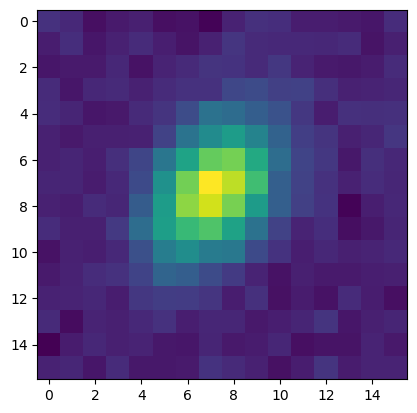

In [449]:
im = m.get_cutout(1623, 0, 'image')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)

# Running metacal

In [450]:
input_name = folder_path + "canvas_grid_isothermal.meds"

In [486]:
outfile_names = folder_path + "canvas_grid_isothermal_mcal" # file name root of output (will have additional _01 _02 etc appended to it)
maxnum = len(objects) # The highest number of  objects to include from the sextractor detection catalog. 


infodicts = mcal.infomaker(maxnum, input_name, outfile_names, nchunk=100)

In [487]:
mcal.multi_mcal(infodicts, nprocess=100)

starting metacal calculations in 100 processes
     Number of calls to function has reached maxfev = 2000.
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
    failure: s2n_sum <= 0.0 : 0.0
        failure: s2n_sum <= 0.0 :  singular covariance0.0

    pars at singular: -0.000952  -0.00172  9.94e-10  3.49e-06     0.315    0.0929 
Total fitting and stacking time: 29.580621480941772 seconds
Total fitting and stacking time: 30.003494024276733 seconds
Total fitting and stacking time: 30.40044069290161 seconds
Total fitting and stacking time: 30.577373266220093 seconds
Total fitting and stacking time: 30.6449236869812 seconds
Total fitting and stacking time: 30.718189477920532 seconds
Total fitting and stacking time: 30.804580211639404 seconds
Total fitting and stacking time: 31.077596187591553 seconds
To

In [488]:
tab = mcal.collater(infodicts)

In [645]:
tshear, rarr = get_tangential(tab["X_IMAGE"], tab["Y_IMAGE"],
                              tab["g_noshear"][:, 0], tab["g_noshear"][:, 1],
                              (2499.5, 2499.5))
rarr *= pixel_scale / 60

In [646]:
resp = (tab["r11"] + tab["r22"]) / 2

In [647]:
def binned_signal(rvals, shears, redges, resps=None):
    
    rcens = redges[:-1] + np.diff(redges) / 2.
    vals = np.zeros(len(rcens))
    vals_err = np.zeros(len(rcens)) # This is the error on the mean, not the std
    respvals = np.zeros(len(rcens))
    for i, tmp in enumerate(redges[:-1]):
        ii = np.where((rvals > redges[i]) & (rvals < redges[i + 1]))[0]
        vals[i] = np.mean(shears[ii])
        vals_err[i] = np.std(shears[ii]) / np.sqrt(len(ii))
        
        if resps is not None:
            respvals[i] = np.mean(resps[ii])
            
    return rcens, vals, vals_err, respvals
        
    

In [648]:
binned_signal(rarr, tshear, np.linspace(0, 14, 10), resp)

(array([ 0.77777778,  2.33333333,  3.88888889,  5.44444444,  7.        ,
         8.55555556, 10.11111111, 11.66666667, 13.22222222]),
 array([0.5692132 , 0.42155008, 0.32459466, 0.27557822, 0.23689997,
        0.20885917, 0.19867464, 0.19710856, 0.16537176]),
 array([0.0203591 , 0.00825546, 0.00599038, 0.00370506, 0.00461032,
        0.00444631, 0.00316675, 0.00717705, 0.00863756]),
 array([0.88066926, 0.92371824, 0.96455434, 0.95861287, 0.89602046,
        0.86392859, 0.91226554, 0.90312806, 0.91965848]))

In [653]:
respvals

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

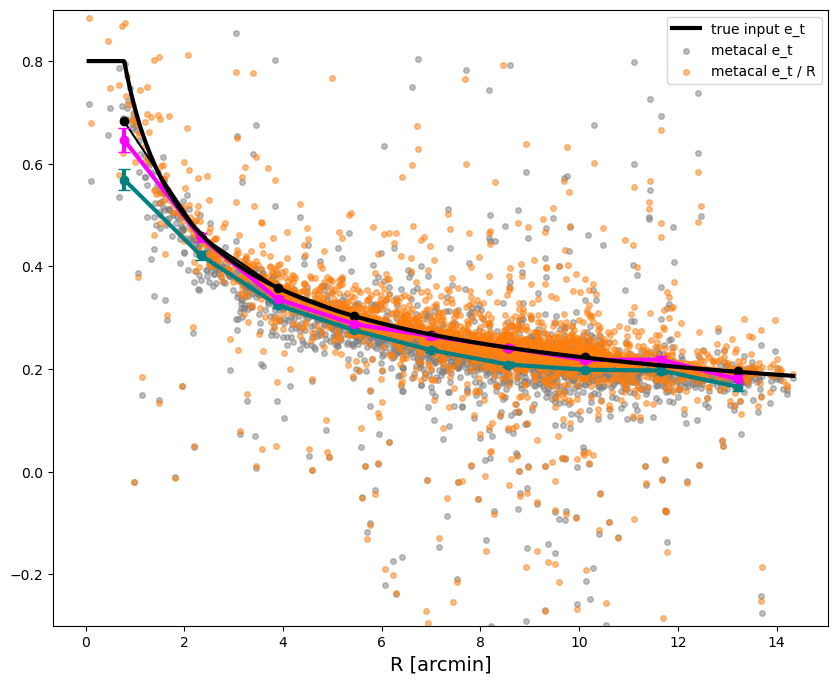

In [654]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# plot the truth curve
iorder = np.argsort(dists)
ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")

redges = np.linspace(0, 14, 10)
rcens, strue, tmp = binned_signal(dists.iloc[iorder].values, shears.iloc[iorder].values, redges)[:-1]
ax.plot(rcens, strue, marker="o", color="black")


ax.scatter(rarr, tshear, s = 16, label="metacal e_t", color="gray", alpha=0.5)
ax.scatter(rarr, tshear / resp, s = 16, label="metacal e_t / R", color="C1", alpha=0.5)

rcens, sraw, sraw_err = binned_signal(rarr, tshear, redges)[:-1]
ax.errorbar(rcens, sraw, sraw_err, marker="o", color="teal", lw=3, capsize=4)

rcens, sraw, sraw_err, respvals = binned_signal(rarr, tshear, redges, resp)
ax.errorbar(rcens, sraw / respvals, sraw_err / respvals, marker="o", color="magenta", lw=3, capsize=4)

ax.set_ylim(-0.3, 0.9)
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_xlabel("R [arcmin]", fontsize=14)

ax.legend()

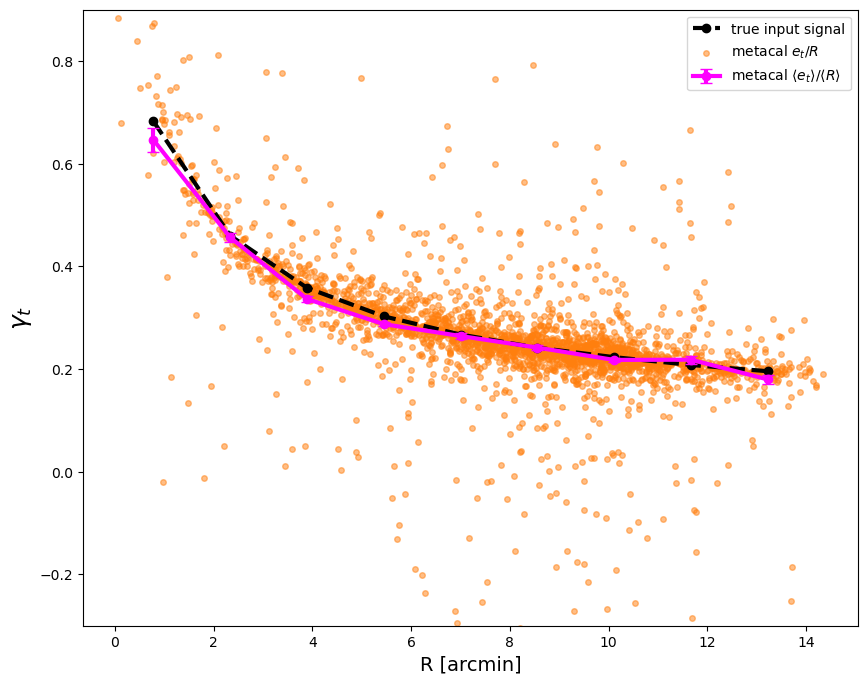

In [675]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# plot the truth curve
# iorder = np.argsort(dists)
# ax.plot(dists.iloc[iorder], shears.iloc[iorder], color="black", zorder=4, lw=3, label="true input e_t")

redges = np.linspace(0, 14, 10)
rcens, strue, tmp = binned_signal(dists.iloc[iorder].values, shears.iloc[iorder].values, redges)[:-1]
ax.plot(rcens, strue, marker="o", color="black", lw=3, ls="--", label="true input signal")


ax.scatter(rarr, tshear / resp, s = 16, label="metacal $e_t / R$", color="C1", alpha=0.5)


rcens, sraw, sraw_err, respvals = binned_signal(rarr, tshear, redges, resp)
ax.errorbar(rcens, sraw / respvals, sraw_err / respvals, label="metacal $\\langle e_t \\rangle / \\langle R \\rangle$",
            marker="o", color="magenta", lw=3, capsize=4, zorder=5)

ax.set_ylim(-0.3, 0.9)
ax.set_xlabel("R [arcmin]", fontsize=14)
ax.set_ylabel("$\gamma_t$", fontsize=18)

ax.legend()
fig.savefig("metacal_field_isothermal_cartoon_v01.png", bbox_inches="tight")

In [491]:
rarr * 60.

array([13.4489777 , 10.17806388, 12.4899197 , 10.52312844, 14.4140714 ,
       13.38170347, 14.59071098, 10.18233212, 14.95986753, 15.73513302,
       16.11753818, 10.67976185, 15.38521521, 12.41069058, 11.98577671,
       13.97042419, 16.55728736, 10.3064767 , 10.14941118, 10.11728564,
       10.15224952, 10.75628199, 10.53736838, 15.49982256, 11.90784985,
       12.34040712, 11.54506866, 16.50753415,  9.99285451, 12.82213509,
       16.4374286 , 15.88117343, 11.45186068,  9.98888021, 15.47926338,
       13.09541551, 12.22286778, 14.25145434, 14.30654232, 15.27036559,
       11.56504264,  9.90812684, 16.37761497, 13.22028403, 15.82123834,
       12.7216983 , 11.30049237, 15.50742458,  9.91467735, 11.66323353,
       10.8877062 , 14.91130892, 14.96613643, 14.84448097, 10.10906068,
       11.53774183, 14.15830055, 16.38664742, 12.71272421,  9.79850242,
       12.86197529,  9.73039391,  9.64502407, 14.3608479 , 14.03902448,
       12.04873641, 11.93392709, 11.81486552,  9.76837668,  9.69